In [9]:
import cv2
import numpy as np
import imutils
from ultralytics import YOLO
import math
import torch
import json

ImportError: cannot import name 'TryExcept' from 'utils' (c:\Users\Abhim\miniconda3\envs\env1\lib\site-packages\utils\__init__.py)

In [2]:
def find_marker(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5) , 0)
    edged = cv2.Canny(gray , 75, 150)

    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)

    return cv2.minAreaRect(c)

def distance_to_camera(knownWidth, focalLength, perWidth):
    return (knownWidth * focalLength) / perWidth

In [3]:
def draw_centroids_on_image(output_image, json_results):   
    data = json.loads(json_results) # Converting JSON array to Python List
    # Accessing each individual object and then getting its xmin, ymin, xmax and ymax to calculate its centroid
    for objects in data:
        xmin = objects["xmin"]
        ymin = objects["ymin"]
        xmax = objects["xmax"]
        ymax = objects["ymax"]
        
        #print("Object: ", data.index(objects))
        #print ("xmin", xmin)
        #print ("ymin", ymin)
        #print ("xmax", xmax)
        #print ("ymax", ymax)
        
        #Centroid Coordinates of detected object
        cx = int((xmin+xmax)/2.0)
        cy = int((ymin+ymax)/2.0)   
        #print(cx,cy)
    
        cv2.circle(output_image, (cx,cy), 2, (0, 0, 255), 2, cv2.FILLED) #draw center dot on detected object
        cv2.putText(output_image, str(str(cx)+" , "+str(cy)), (int(cx)-40, int(cy)+30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

    return (output_image)

In [4]:
KNOWN_DISTANCE = 17.50
KNOWN_WIDTH = 11.81

img_path = r"C:\Users\Abhim\Documents\Python_Programs\ArrowDetect\DatasetV3\test\images\test1frame0065_png.rf.0fe9db2aff737a1231ccb7308bb91db8.jpg"
image = cv2.imread(img_path)
marker = find_marker(image)
focalLength = (marker[1][0] * KNOWN_DISTANCE) / KNOWN_WIDTH

Using cache found in C:\Users\Abhim/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-10-18 Python-3.10.10 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


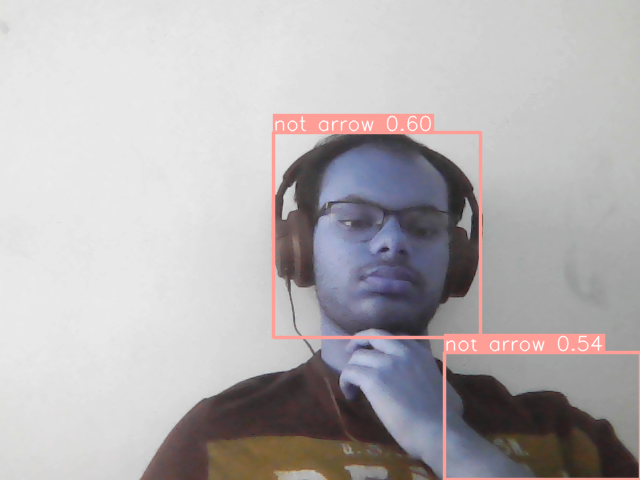

image 1/1: 480x640 2 not arrows
Speed: 0.0ms pre-process, 9.0ms inference, 6.5ms NMS per image at shape (1, 3, 480, 640)
tensor([[2.73992e+02, 1.32414e+02, 4.80042e+02, 3.37877e+02, 6.04059e-01, 1.00000e+00],
        [4.44100e+02, 3.52836e+02, 6.40000e+02, 4.79831e+02, 5.41559e-01, 1.00000e+00]], device='cuda:0')
[tensor([[2.73992e+02, 1.32414e+02, 4.80042e+02, 3.37877e+02, 6.04059e-01, 1.00000e+00],
        [4.44100e+02, 3.52836e+02, 6.40000e+02, 4.79831e+02, 5.41559e-01, 1.00000e+00]], device='cuda:0')]
178.05246930985388


AttributeError: 'NoneType' object has no attribute 'shape'

In [12]:
cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)

model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5\yolov5m_25epochs.pt')
model.eval()
classNames = ['arrow','not arrow']
while True:
    ret, video = cap.read()
    
    results = model(video)
    results.show()
    print (results)
    print (results.xyxy[0])
    print (results.xyxy)

    json_results = results.pandas().xyxy[0].to_json(orient="records") # im predictions (JSON)
    results.render()  # updates results.imgs with boxes and labels                    
    output_image = results.ims[0] #output image after rendering // results.ims is correct (not results.imgs)
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)           
    output_image = draw_centroids_on_image(output_image, json_results) # Draw Centroids on the deteted objects and returns updated imag
    video = output_image
    cv2.imshow("Output", video) #Show the output image after rendering
    marker = find_marker(video)
    dist = distance_to_camera(KNOWN_WIDTH, focalLength, marker[1][0])
    print (dist)

    if cv2.waitKey(0) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()